## MG figures

In [1]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from wfOpto import *

plt.style.use(r'C:\Users\nadia\OneDrive\Documents\GitHub\steinmetzlab\calcium imaging\ALpres.mplstyle')

pytoolsAL: Modules missing.  Not loading neuropixels.  Message: No module named 'slidingRP'
pytoolsAL: Modules missing.  Not loading plotting.  Message: No module named 'pandas'


### loading data

In [2]:
data830 = wfOpto((Path(r'Z:\Subjects\AL_0023\2023-08-30\1')), listExps=[np.r_[:1350], np.r_[1350:1800]])
data717 = wfOpto(Path(r'Z:\Subjects\ZYE_0069\2023-07-17\1'), [np.r_[:334], np.r_[334:667]])

In [28]:
# process 717
pixel_ix = np.ravel_multi_index((246,198), (data717.py, data717.py)) # the pixel
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

trials = np.squeeze(np.argwhere(data717.laserPowers[data717.listExps[0]]==3.2)) # the trials
time = [np.linspace(-.3+i, i+1, n_samples) for i in data717.laserOn[data717.listExps[0][trials]]] 
trs = np.squeeze(np.array(time))

opto = []
for iT, tr in enumerate(time):
    wf = data717.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data717.svdSpat[pixel_ix] @ dwf
    opto.append(mov)
opto = np.array(opto)

In [18]:
# process 830
power = 3
pixel = (410, 428)
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
pows = np.argwhere(data830.laserPowers[data830.listExps[0]] == power).ravel()
onTimes = data830.laserOn[data830.listExps[0]][pows]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

flicker = []
for iT, tr in enumerate(trs):
    wf = data830.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data830.svdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

### panels

In [138]:
def mouseImg(ax):
    im_f = r'C:\Users\nadia\Downloads\optowf.png'
    im = plt.imread(im_f)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.text(.5,.05,'screen',transform=ax.transAxes,ha='center',va='bottom',fontsize='medium')
    plt.text(0, .67, 'laser', transform=ax.transAxes,ha='left',va='center',fontsize='medium', c='red')

In [156]:
def taskImg(ax):
    im_f = r'C:\Users\nadia\Downloads\task.png'
    im = plt.imread(im_f)
    plt.imshow(im[0:650, 20:570])
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [182]:
def panelOptoVisResp(ax, ylim):
    flicker_mean = np.mean(flicker, axis=0)
    opto_mean = np.mean(opto, axis=0)
    flicker_scale = flicker_mean*.45454545

    ax.plot(timestamps, opto_mean, color='red')
    # ax.set_title("Optogenetic Stimulation and \nVisual Response Activity Traces")
    ax.set_ylabel('Brain activity')
    ax.plot(timestamps,flicker_scale,color='blue')
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    ax.legend(['opto resp','visual resp'])
    ax.set_ylim(ylim)
    plt.xticks([0, 500, 1000], [0, 0.5, 1])
    plt.xlabel('Time from stim onset (s)')

In [187]:
def panelConfoundResp(ax, ylim):
    flicker_mean = np.mean(flicker, axis=0)
    opto_mean = np.mean(opto, axis=0)
    flicker_scale = flicker_mean*.45454545
    
    ax.plot(timestamps,flicker_scale+opto_mean,color='darkviolet')
    # ax.set_title("Resultant brain activity of \nOpto. and Visual Responses")
    ax.set_ylim(ylim)
    # plt.tick_params(axis='y', labelleft=False)
    plt.text(0.95, 0.95, 'Resultant brain activity of\nopto and visual responses', 
             transform=ax.transAxes, ha='right', va='top', fontsize='x-small')
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.xticks([0, 500, 1000], [0, 0.5, 1])
    plt.xlabel('Time from stim onset (s)')
    plt.ylabel('Brain activity')

In [184]:
def panelPowerWithFlicker(ax):
    pixel = (410, 428)
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    
    pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
    pows = np.argwhere(data830.laserPowers[data830.listExps[1]] == power).ravel()
    onTimes = data830.laserOn[data830.listExps[1]][pows]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    noFlicker = []
    for iT, tr in enumerate(trs):
        wf = data830.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = data830.svdSpat[pixel_ix] @ dwf
        noFlicker.append(mov)
    noFlicker = np.array(noFlicker)
    # plt.plot(timestamps, np.mean(noFlicker, axis=0))
    # plt.title(f'power {power}')
    # plt.xlabel('time (ms)')
    # plt.ylabel('$\Delta F$')
    colors = ['forestgreen', 'darkorange']
    plt.plot(timestamps, np.mean(noFlicker, axis=0), color=colors[0], label='without flicker')
    plt.fill_between(timestamps, \
                     np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                     np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color=colors[0], alpha=0.3, lw=0, label='_nolegend_')
    
    plt.plot(timestamps, np.mean(flicker,axis=0),color=colors[1], label='with flicker')
    plt.fill_between(timestamps, \
                     np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                     np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color=colors[1], lw=0, label='_nolegend_', alpha=0.3)
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.legend()
    plt.ylim(None, 30)
    plt.xticks([0, 500, 1000], [0, 0.5, 1])
    plt.xlabel('Time from stim onset(s)')
    plt.ylabel('Visual response')
    plt.title(f'{power} mW opto stim')

In [185]:
def panelAllPowersFlicker(ax):
    powers = np.unique(data830.laserPowers)
    pixel = (410, 428)
    pxPowersFlicker = [] 
    pxPowersNoFlicker = []
    n_samples = 650
    
    pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
    for iP, power in enumerate(powers):
        if power >= 0:
            theseTrsFlicker = np.argwhere(data830.laserPowers[data830.listExps[0]]== power).ravel()
            # theseTrsFlicker=theseTrsFlicker[::3]
            onTimesFlicker = data830.laserOn[data830.listExps[0]][theseTrsFlicker]
            trsFlicker = [np.linspace(on+0, .25+on, n_samples) for on in onTimesFlicker]
            trsFlicker = np.squeeze(np.array(trsFlicker))
            
            theseTrsNFlicker = np.argwhere(data830.laserPowers[data830.listExps[1]]== power).ravel()
            onTimesNFlicker = data830.laserOn[data830.listExps[1]][theseTrsNFlicker]
            trsNFlicker = [np.linspace(0+on, .25+on, n_samples) for on in onTimesNFlicker]
            trsNFlicker = np.squeeze(np.array(trsNFlicker))
            
            thisPowerNFlicker = []
            thisPowerFlicker = []
            for iT, tr in enumerate(trsFlicker):
                wf = data830.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = data830.svdSpat[pixel_ix] @ dwf
                thisPowerFlicker.append(mov)
            thisPowerFlicker = np.array(thisPowerFlicker)
            pxPowersFlicker.append(thisPowerFlicker)
    
            for iT, tr in enumerate(trsNFlicker):
                wf = data830.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = data830.svdSpat[pixel_ix] @ dwf
                thisPowerNFlicker.append(mov)
            thisPowerNFlicker = np.array(thisPowerNFlicker)
            pxPowersNoFlicker.append(thisPowerNFlicker)   
    
    flickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        flickInt.append(int)
    flickInt = np.array(flickInt)
    
    noflickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersNoFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        noflickInt.append(int)
    noflickInt = np.array(noflickInt)
    # plt.plot(np.unique(data830.laserPowers),noflickInt,c='red')

    dotkwargs = {'marker': '.', 'yerr': 0}
    constant = 100
    plt.errorbar(np.unique(data830.laserPowers), noflickInt/constant, c='forestgreen', label='without flicker', **dotkwargs)
    
    # plt.plot(np.unique(data830.laserPowers),flickInt,c='blue')
    plt.errorbar(np.unique(data830.laserPowers), flickInt/constant, c='darkorange', label='with flicker', **dotkwargs)
    
    plt.legend()
    plt.xlabel('Optogenetic laser power (mW)')
    plt.ylabel('Visual response')
    # plt.title('Magnitude of Visual Response')

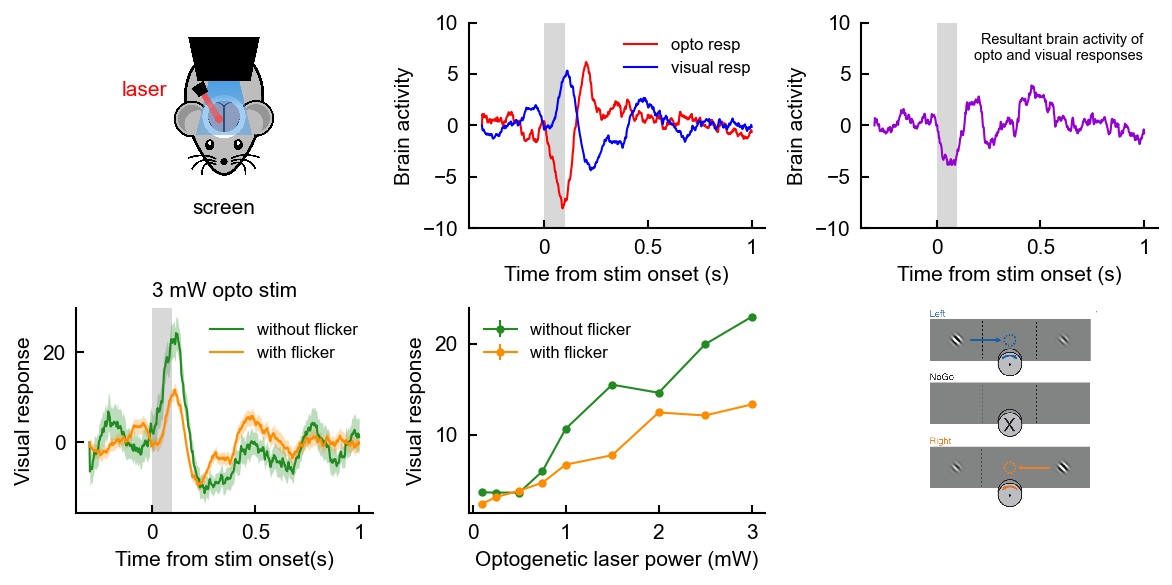

In [188]:
f = plt.figure(figsize=(8, 4))
gs = mpl.gridspec.GridSpec(2, 3)

ax = plt.subplot(gs[0])
mouseImg(ax)

ax = plt.subplot(gs[1])
ylim = (-10, 10)
panelOptoVisResp(ax, ylim)

ax = plt.subplot(gs[2])
panelConfoundResp(ax, ylim)

ax = plt.subplot(gs[3])
panelPowerWithFlicker(ax)

ax = plt.subplot(gs[4])
panelAllPowersFlicker(ax)

ax = plt.subplot(gs[5])
taskImg(ax)

f.tight_layout()

### ignore below

NameError: name 'ax' is not defined

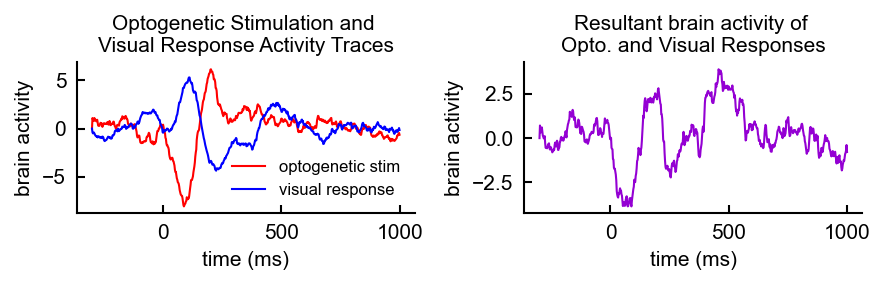

In [7]:
fig, axs = plt.subplots(1,2,figsize=(6,2))
flicker_scale = flicker*.45454545

axs[0].plot(timestamps,opto,color='red')
axs[0].set_title("Optogenetic Stimulation and \nVisual Response Activity Traces")
axs[0].set_xlabel('time (ms)')
axs[0].set_ylabel('brain activity')
axs[0].plot(timestamps,flicker_scale,color='blue')
axs[0].legend(['optogenetic stim','visual response'])

axs[1].plot(timestamps,flicker_scale+opto,color='darkviolet')
axs[1].set_title("Resultant brain activity of \nOpto. and Visual Responses")
axs[1].set_xlabel('time (ms)')
axs[1].set_ylabel('brain activity')

## text
plt.text(0.95, 0.05, 'Resulting brain activity of\nopto and visual responses', c='k', 
         transform=ax.transAxes, ha='right', va='bottom', fontsize='xx-small')

plt.show()

# brain activity

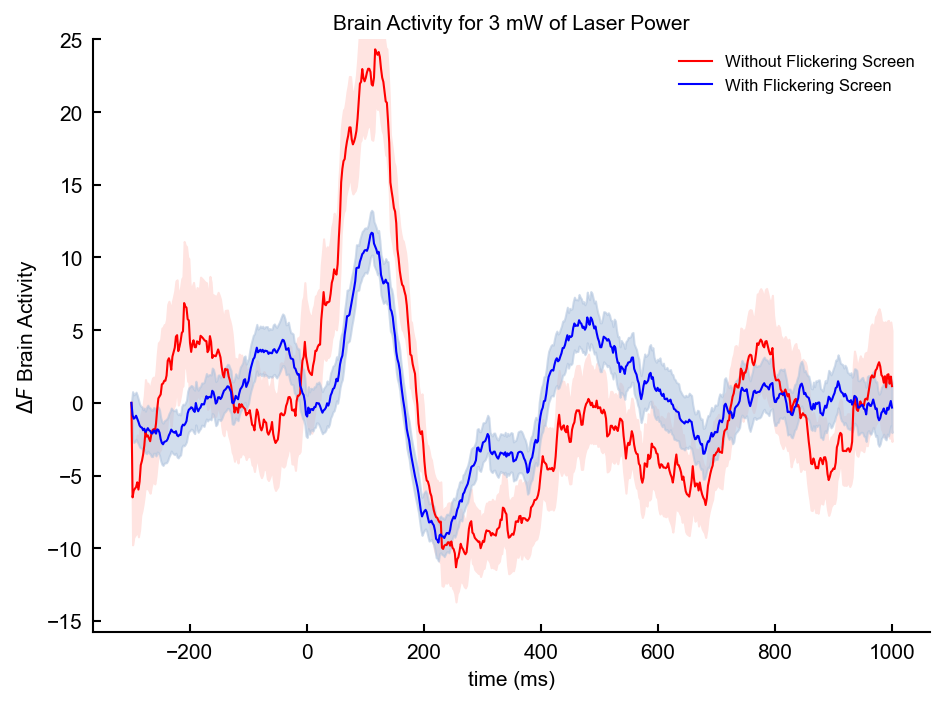

In [11]:
# plot single power

pixel = (410, 428)
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
pows = np.argwhere(data830.laserPowers[data830.listExps[1]] == power).ravel()
onTimes = data830.laserOn[data830.listExps[1]][pows]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

noFlicker = []
for iT, tr in enumerate(trs):
    wf = data830.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data830.svdSpat[pixel_ix] @ dwf
    noFlicker.append(mov)
noFlicker = np.array(noFlicker)
# plt.plot(timestamps, np.mean(noFlicker, axis=0))
# plt.title(f'power {power}')
# plt.xlabel('time (ms)')
# plt.ylabel('$\Delta F$')
plt.plot(timestamps, np.mean(noFlicker, axis=0),color='red')
plt.fill_between(timestamps, \
                 np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                 np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color='mistyrose', label='_nolegend_')
plt.plot(timestamps, np.mean(flicker,axis=0),color='blue')
plt.fill_between(timestamps, \
                 np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                 np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color='lightsteelblue', label='_nolegend_',alpha=.57777)
plt.legend(['Without Flickering Screen', 'With Flickering Screen'])
plt.ylim(top=25)
plt.legend(['Without Flickering Screen', 'With Flickering Screen'])
plt.xlabel('time (ms)')
plt.ylabel('$\Delta F$ Brain Activity')
plt.title(f'Brain Activity for {power} mW of Laser Power')
plt.show()

# magnitude visual response

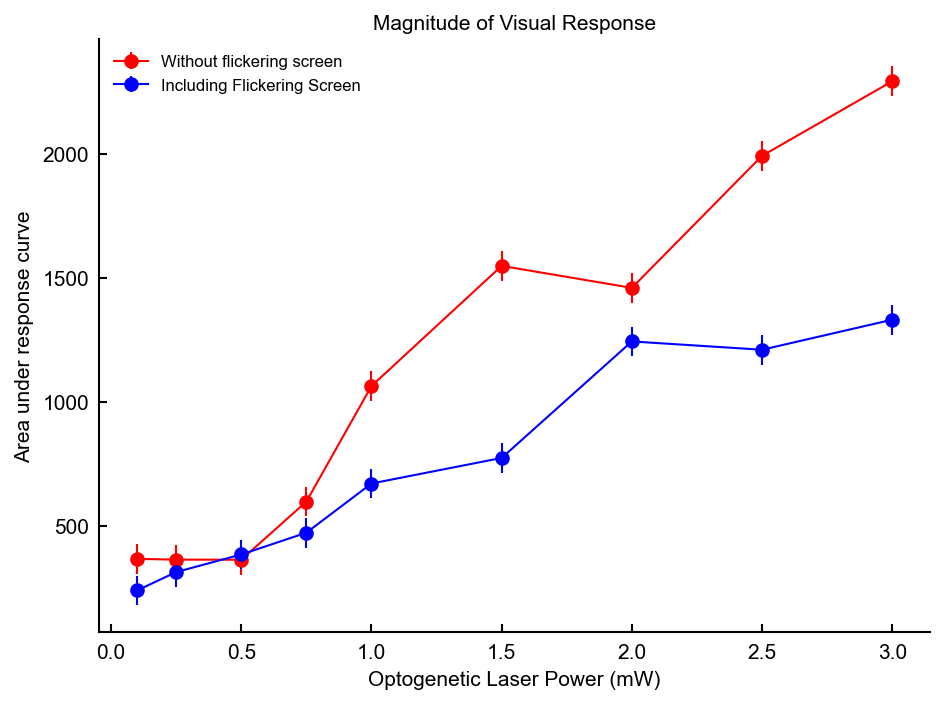

In [12]:
powers = np.unique(data830.laserPowers)
pixel = (410, 428)
pxPowersFlicker = [] 
pxPowersNoFlicker = []
n_samples = 650

pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
for iP, power in enumerate(powers):
    if power >= 0:
        theseTrsFlicker = np.argwhere(data830.laserPowers[data830.listExps[0]]== power).ravel()
        # theseTrsFlicker=theseTrsFlicker[::3]
        onTimesFlicker = data830.laserOn[data830.listExps[0]][theseTrsFlicker]
        trsFlicker = [np.linspace(on+0, .25+on, n_samples) for on in onTimesFlicker]
        trsFlicker = np.squeeze(np.array(trsFlicker))
        
        theseTrsNFlicker = np.argwhere(data830.laserPowers[data830.listExps[1]]== power).ravel()
        onTimesNFlicker = data830.laserOn[data830.listExps[1]][theseTrsNFlicker]
        trsNFlicker = [np.linspace(0+on, .25+on, n_samples) for on in onTimesNFlicker]
        trsNFlicker = np.squeeze(np.array(trsNFlicker))
        
        thisPowerNFlicker = []
        thisPowerFlicker = []
        for iT, tr in enumerate(trsFlicker):
            wf = data830.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data830.svdSpat[pixel_ix] @ dwf
            thisPowerFlicker.append(mov)
        thisPowerFlicker = np.array(thisPowerFlicker)
        pxPowersFlicker.append(thisPowerFlicker)

        for iT, tr in enumerate(trsNFlicker):
            wf = data830.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data830.svdSpat[pixel_ix] @ dwf
            thisPowerNFlicker.append(mov)
        thisPowerNFlicker = np.array(thisPowerNFlicker)
        pxPowersNoFlicker.append(thisPowerNFlicker)   

flickInt = []
time=np.linspace(0,0.25,650)
for count,pxPowers in enumerate(pxPowersFlicker):
    pxPowers = np.mean(pxPowers, axis=0)
    min = np.min(pxPowers)
    pxPowers = pxPowers+ (min*-1)
    int = np.trapz(y=pxPowers)
    flickInt.append(int)
flickInt = np.array(flickInt)

noflickInt = []
time=np.linspace(0,0.25,650)
for count,pxPowers in enumerate(pxPowersNoFlicker):
    pxPowers = np.mean(pxPowers, axis=0)
    min = np.min(pxPowers)
    pxPowers = pxPowers+ (min*-1)
    int = np.trapz(y=pxPowers)
    noflickInt.append(int)
noflickInt = np.array(noflickInt)
# plt.plot(np.unique(data830.laserPowers),noflickInt,c='red')
plt.errorbar(np.unique(data830.laserPowers),noflickInt,marker='o',yerr=60,c='red')

# plt.plot(np.unique(data830.laserPowers),flickInt,c='blue')
plt.errorbar(np.unique(data830.laserPowers),flickInt,marker='o',yerr=60,c='blue')

plt.legend(['Without flickering screen','Including Flickering Screen'])
plt.xlabel('Optogenetic Laser Power (mW)')
plt.ylabel('Area under response curve')
plt.title('Magnitude of Visual Response')
plt.show()

# graveyard

In [ ]:

flicker = np.array(flicker)
plt.plot(timestamps, np.mean(flicker, axis=0))
plt.title(f'power {power}')
plt.xlabel('time (ms)')
plt.ylabel('$\Delta F$')

In [ ]:
ig, axs = plt.subplots(1,3,figsize=(10,3))
flicker_scale = flicker*.45454545
axs[0].plot(timestamps,opto)
axs[0].set_title("Optogenetic Stimulation")
axs[0].set_xlabel('time (ms)')
axs[0].set_ylabel('brain activity')
axs[1].plot(timestamps,flicker_scale)
axs[1].set_title("Visual Response")
axs[1].set_xlabel('time (ms)')
axs[1].set_ylabel('brain activity')
axs[2].plot(timestamps,flicker_scale+opto)
axs[2].set_title("Resultant brain activity of\nOpto. and Visual Responses")
axs[2].set_xlabel('time (ms)')
axs[2].set_ylabel('brain activity')

plt.show()